In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
import numpy as np
import glob
import re
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
# python -m spacy download en_core_web_sm
#nltk stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#pandas
import pandas as pd

#vis
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

[nltk_data] Downloading package stopwords to /home/lennarth/Documents/
[nltk_data]     GitHub/nlp_project/venv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2022-07-17 12:23:41,126 : INFO : NumExpr defaulting to 8 threads.
/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [2]:
df = pd.read_csv("../../data/ExtractedTweets.csv")
df.head()

# separate dataframes for both parties
df_dem = df.query("Party == 'Democrat'")#.sample(1000)
df_rep = df.query("Party == 'Republican'")#.sample(1000)

### Extract tweet information

In [3]:
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

# make new columns for retweeted usernames, mentioned usernames and hashtags
df_dem = df_dem.assign(retweeted=df_dem['Tweet'].apply(find_retweeted))
df_dem = df_dem.assign(mentioned=df_dem['Tweet'].apply(find_mentioned))
df_dem = df_dem.assign(hashtags=df_dem['Tweet'].apply(find_hashtags))

df_rep = df_rep.assign(retweeted=df_rep['Tweet'].apply(find_retweeted))
df_rep = df_rep.assign(mentioned=df_rep['Tweet'].apply(find_mentioned))
df_rep = df_rep.assign(hashtags=df_rep['Tweet'].apply(find_hashtags))

print("Extracted tweet metadata")

Extracted tweet metadata


### Clean metioned, retweets and hashtags from tweet

In [4]:
stop_words = stopwords.words('english')
stop_words.append("rt")

def clean_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.sub('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.sub('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean(tweet):
    # Remove mentions, retweets and hashtags
    tweet = clean_hashtags(tweet)
    tweet = clean_mentioned(tweet)
    tweet = clean_retweeted(tweet)
    tweet = tweet.lower()
    # Remove punctuation
    tweet = re.sub("[\\.,;:\\-!/\\?]*", "", tweet)
    # Remove links
    tweet = re.sub(r"http\S+", "", tweet)
    # Remove stop words
    tweet = ' '.join([word for word in tweet.split(' ') if not word in stop_words])
    # Remove multiple spaces
    tweet = re.sub("\\s+", " ", tweet)
    return tweet

df_dem = df_dem.assign(TweetCleaned=df_dem['Tweet'].apply(clean))
df_rep = df_rep.assign(TweetCleaned=df_rep['Tweet'].apply(clean))

print("Cleaned tweets")

Cleaned tweets


### Lemmatize the text

In [5]:
import warnings
# Ignore DeprecationWarning from SelectableGroups
warnings.filterwarnings("ignore", category=DeprecationWarning)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatization(tweet, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    doc = nlp(tweet)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    return final

df_dem['TweetCleaned'] = df_dem['TweetCleaned'].apply(lemmatization)
df_rep['TweetCleaned'] = df_rep['TweetCleaned'].apply(lemmatization)

print("Lemmatized tweets")

Lemmatized tweets


In [6]:
def gen_words(tweet):
    # Use gensims simple_preprocess to remove accents, lowercase and tokenize
    return gensim.utils.simple_preprocess(tweet, deacc=True)

df_dem['TweetWords'] = df_dem['TweetCleaned'].apply(gen_words)
df_rep['TweetWords'] = df_rep['TweetCleaned'].apply(gen_words)

print("Generated tokens")

Generated tokens


In [7]:
# BIGRAMS AND TRIGRAMS
# DEM
bigram_phrases_dem = gensim.models.Phrases(df_dem['TweetWords'], min_count=5, threshold=100)
trigram_phrases_dem = gensim.models.Phrases(bigram_phrases_dem[df_dem['TweetWords']], threshold=100)

bigram_dem = gensim.models.phrases.Phraser(bigram_phrases_dem)
trigram_dem = gensim.models.phrases.Phraser(trigram_phrases_dem)

# REP
bigram_phrases_rep = gensim.models.Phrases(df_rep['TweetWords'], min_count=5, threshold=100)
trigram_phrases_rep = gensim.models.Phrases(bigram_phrases_rep[df_rep['TweetWords']], threshold=100)

bigram_rep = gensim.models.phrases.Phraser(bigram_phrases_rep)
trigram_rep = gensim.models.phrases.Phraser(trigram_phrases_rep)

def make_bigrams_dem(tweetWords):
    return bigram_dem[tweetWords]

def make_trigrams_dem(bigrams):
    return trigram_dem[bigram_dem[bigrams]]

def make_bigrams_rep(tweetWords):
    return bigram_rep[tweetWords]

def make_trigrams_rep(bigrams):
    return trigram_rep[bigram_rep[bigrams]]


df_dem['bigramms'] = df_dem['TweetWords'].apply(make_bigrams_dem)
df_dem['trigrams'] = df_dem['bigramms'].apply(make_trigrams_dem)

df_rep['bigramms'] = df_rep['TweetWords'].apply(make_bigrams_rep)
df_rep['trigrams'] = df_rep['bigramms'].apply(make_trigrams_rep)


print("Generated trigrams")

Generated trigrams


In [8]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel
low_value = 0.03

# DEM
id2word_dem = corpora.Dictionary(df_dem['trigrams'])
texts_dem = df_dem['trigrams']
corpus_dem = [id2word_dem.doc2bow(text) for text in texts_dem]

tfidf_dem = TfidfModel(corpus_dem, id2word=id2word_dem)

words_dem  = []
words_missing_in_tfidf_dem = []
for i in range(0, len(corpus_dem)):
    bow = corpus_dem[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf_dem[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf_dem[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf_dem
    for item in drops:
        words_dem.append(id2word_dem[item])
    words_missing_in_tfidf_dem = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf_dem]
    corpus_dem[i] = new_bow

# REP
id2word_rep = corpora.Dictionary(df_rep['trigrams'])
texts_rep = df_rep['trigrams']
corpus_rep = [id2word_rep.doc2bow(text) for text in texts_rep]

tfidf_rep = TfidfModel(corpus_rep, id2word=id2word_rep)

words_rep  = []
words_missing_in_tfidf_rep = []
for i in range(0, len(corpus_rep)):
    bow = corpus_rep[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf_rep[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf_rep[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf_rep
    for item in drops:
        words_rep.append(id2word_rep[item])
    words_missing_in_tfidf_rep = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf_rep]
    corpus_rep[i] = new_bow

print("TF-IDF removal")
print("Finish preprocessing")

TF-IDF removal
Finish preprocessing


In [9]:
import pickle

file = open("data_dem.bin", "wb")
pickle.dump((df_dem, id2word_dem, corpus_dem, tfidf_dem), file)

file = open("data_rep.bin", "wb")
pickle.dump((df_rep, id2word_rep, corpus_rep, tfidf_rep), file)

In [8]:
import pickle
(df_dem, id2word_dem, corpus_dem, tfidf_dem) = pickle.load(open("data_dem.bin", "rb"))
(df_rep, id2word_rep, corpus_rep, tfidf_rep) = pickle.load(open("data_rep.bin", "rb"))

In [ ]:
lda_model_dem = gensim.models.LdaMulticore(
                corpus=corpus_dem[:-1],
                id2word=id2word_dem,
                num_topics=2,
                random_state=100,
                chunksize=100,
                passes=10,
                workers=3
            )

lda_model_rep = gensim.models.LdaMulticore(
                corpus=corpus_rep[:-1],
                id2word=id2word_rep,
                num_topics=2,
                random_state=100,
                chunksize=100,
                passes=10,
                workers=3
            )

NameError: name 'gensim' is not defined

In [ ]:
vis = pyLDAvis.gensim_models.prepare(lda_model_dem, corpus_dem, id2word_dem, mds="mmds", R=30)
vis

/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWar

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.012266 -0.216469       1        1  52.793494
0      0.012266  0.216469       2        1  47.206506, topic_info=        Term         Freq        Total Category  logprob  loglift
23     thank  2325.000000  2325.000000  Default  30.0000  30.0000
54      join  1762.000000  1762.000000  Default  29.0000  29.0000
6      today  3714.000000  3714.000000  Default  28.0000  28.0000
52     great  1619.000000  1619.000000  Default  27.0000  27.0000
122  student  1437.000000  1437.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
394     work  1055.720943  2061.708776   Topic2  -4.8711   0.0813
204      see   698.943577  1132.425622   Topic2  -5.2835   0.2681
352      new   643.440817   935.082142   Topic2  -5.3662   0.3768
557     help   642.421759  1056.363626   Topic2  -5.3678   0.2533
412      day   563.104257  1224.873653   Topic2  -5.4996  -0.0265

[119 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1314      1  0.997715          action
1314      2  0.001893          action
369       1  0.997240  administration
369       2  0.002899  administration
975       1  0.998939        american
...     ...       ...             ...
394       2  0.512196            work
63        1  0.996001            year
63        2  0.004359            year
286       1  0.002386       yesterday
286       2  0.999572       yesterday

[173 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [ ]:
vis = pyLDAvis.gensim_models.prepare(lda_model_rep, corpus_rep, id2word_rep, mds="mmds", R=30)
vis

/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.063959  0.201901       1        1  53.949724
1      0.063959 -0.201901       2        1  46.050276, topic_info=          Term         Freq        Total Category  logprob  loglift
44       thank  2912.000000  2912.000000  Default  30.0000  30.0000
67       great  2593.000000  2593.000000  Default  29.0000  29.0000
286        tax  2454.000000  2454.000000  Default  28.0000  28.0000
77        join  1556.000000  1556.000000  Default  27.0000  27.0000
65         day  1539.000000  1539.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
335       work   924.544898  1963.013295   Topic2  -5.0182   0.0225
270  community   608.843644   800.325248   Topic2  -5.4359   0.5020
349       come   577.470607   766.422717   Topic2  -5.4888   0.4924
182       time   659.517315  1399.616265   Topic2  -5.3560   0.0230
313       many   569.507250   728.780855   Topic2  -5.5027   0.5288

[121 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
261       1  0.999076        act
261       2  0.000905        act
235       1  0.002212     always
235       2  0.999740     always
46        1  0.998853   american
...     ...       ...        ...
335       2  0.471214       work
94        1  0.456130       year
94        2  0.544079       year
133       1  0.001671  yesterday
133       2  0.999104  yesterday

[168 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

/home/lennarth/Documents/GitHub/nlp_project/venv/lib64/python3.10/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/lennarth/Documents/GitHub/nlp_project/venv/lib64/python3.10/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/lennarth/Documents/GitHub/nlp_project/venv/lib64/python3.10/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/home/lennarth/Documents/GitHub/nlp_project/venv/lib64/python3.10/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecate

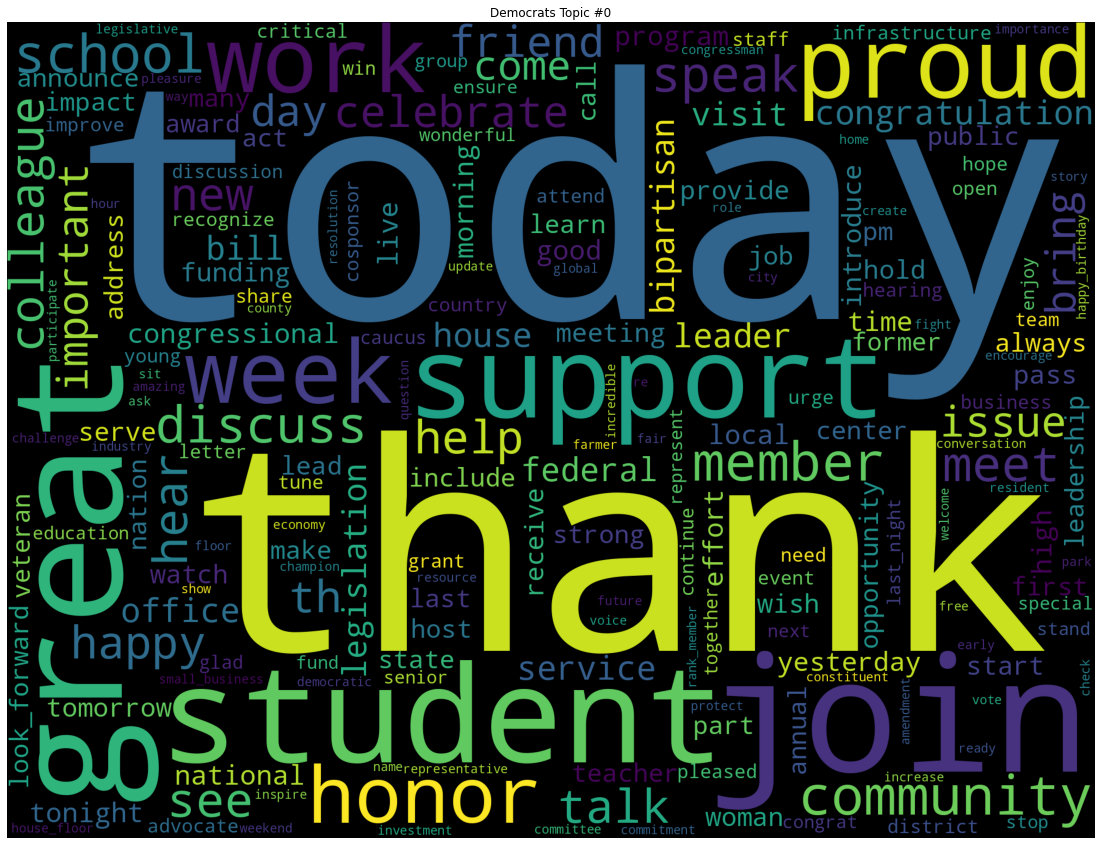

/home/lennarth/Documents/GitHub/nlp_project/venv/lib64/python3.10/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/home/lennarth/Documents/GitHub/nlp_project/venv/lib64/python3.10/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/home/lennarth/Documents/GitHub/nlp_project/venv/lib64/python3.10/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/lennarth/Documents/GitHub/nlp_project/venv/lib64/python3.10/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-0

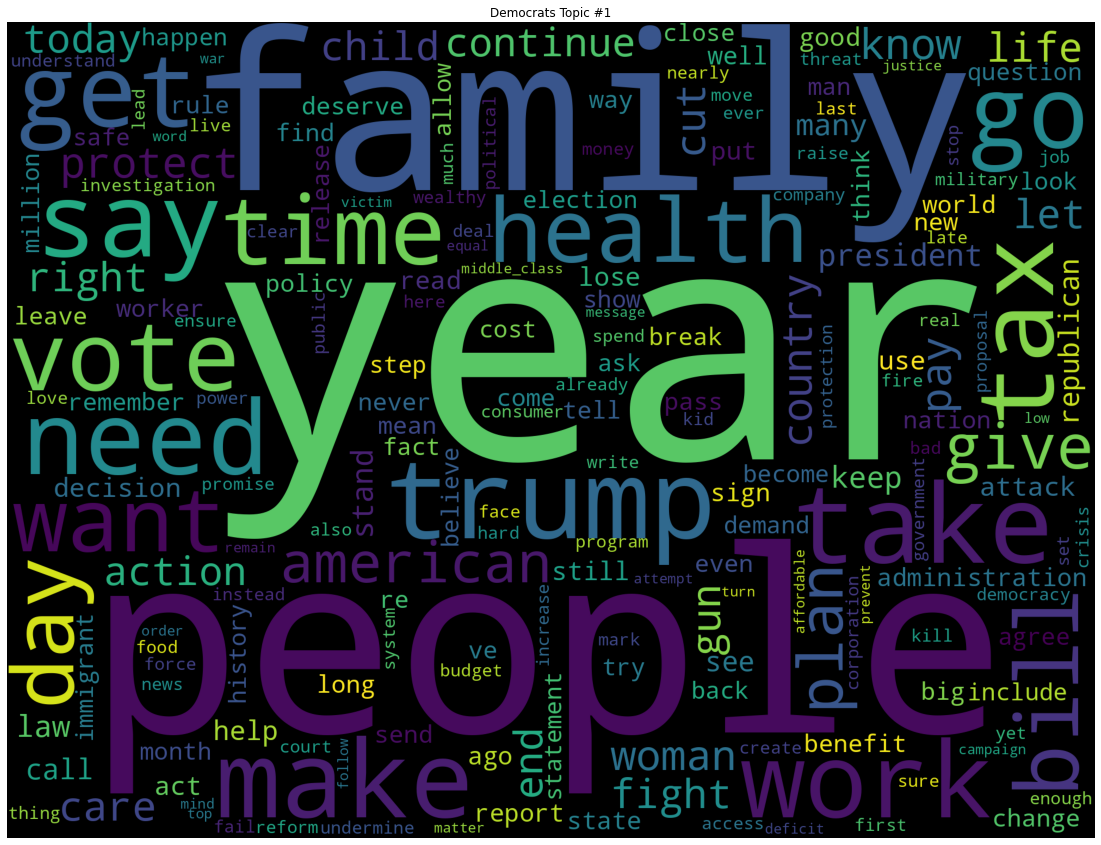

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

for t in range(lda_model_dem.num_topics):
    cloud = WordCloud(width=2000,height=1500)
    plt.figure(figsize=(20,15))
    plt.imshow(cloud.fit_words(dict(lda_model_dem.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Democrats Topic #" + str(t))
    plt.show()

/home/lennarth/Documents/GitHub/nlp_project/venv/lib64/python3.10/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/lennarth/Documents/GitHub/nlp_project/venv/lib64/python3.10/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/lennarth/Documents/GitHub/nlp_project/venv/lib64/python3.10/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/lennarth/Documents/GitHub/nlp_project/venv/lib64/python3.10/site-packages/wordcloud/wordcloud.py:519: DeprecationWa

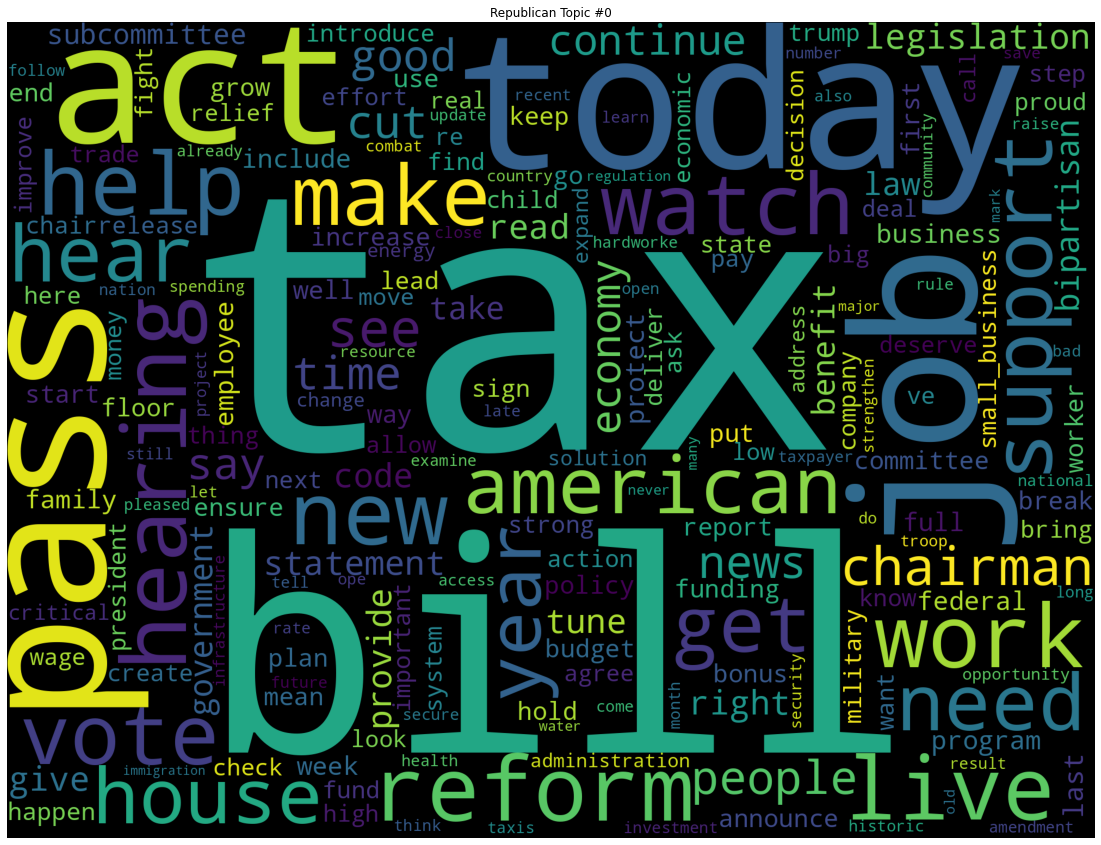

/home/lennarth/Documents/GitHub/nlp_project/venv/lib64/python3.10/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/lennarth/Documents/GitHub/nlp_project/venv/lib64/python3.10/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/home/lennarth/Documents/GitHub/nlp_project/venv/lib64/python3.10/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/home/lennarth/Documents/GitHub/nlp_project/venv/lib64/python3.10/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-0

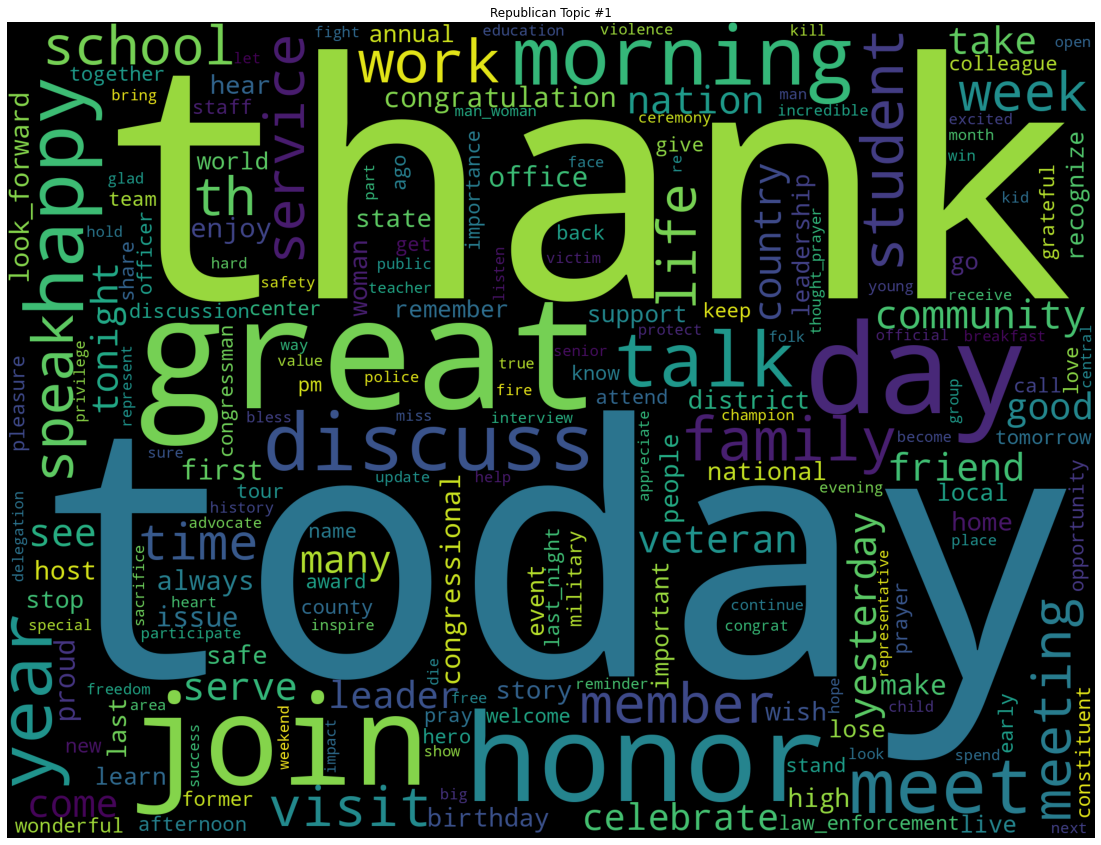

In [ ]:
for t in range(lda_model_rep.num_topics):
    cloud = WordCloud(width=2000,height=1500)
    plt.figure(figsize=(20,15))
    plt.imshow(cloud.fit_words(dict(lda_model_rep.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Republican Topic #" + str(t))
    plt.show()

# Compare LDA Models

In [ ]:
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def plot_difference_plotly(mdiff, title="", annotation=None):
    """Plot the difference between models.

    Uses plotly as the backend."""
    import plotly.offline as py
    import plotly.graph_objs as go

    annotation_html = None
    if annotation is not None:
        annotation_html = [
            [
                "+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens))
                for (int_tokens, diff_tokens) in row
            ]
            for row in annotation
        ]

    data = go.Heatmap(z=mdiff, colorscale='RdBu', text=annotation_html)
    layout = go.Layout(width=950, height=950, title=title, xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))


def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)


try:
    get_ipython()
    import plotly.offline as py
except Exception:
    print('lol')
    #
    # Fall back to matplotlib if we're not in a notebook, or if plotly is
    # unavailable for whatever reason.
    #
    plot_difference = plot_difference_matplotlib
else:
    py.init_notebook_mode()
    plot_difference = plot_difference_plotly

In [ ]:
mdiff, annotation = lda_model_dem.diff(
        lda_model_rep,
        distance='jaccard',
        #num_words=50
    )
plot_difference(mdiff, title="Topic difference (two models)[jaccard distance]", annotation=annotation)

/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [ ]:
import numpy as np
mdiff = np.ones((15,15))
np.fill_diagonal(mdiff, 0.)
plot_difference(mdiff, title="Topic difference (one model) in ideal world")